In [1]:
import csv
import gzip
import re

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from collections import defaultdict

In [4]:
long_data = list()

In [5]:
exon_type_repr = {
    '5': {'background': defaultdict(lambda: 0), 'new': defaultdict(lambda: 0)},
    '3': {'background': defaultdict(lambda: 0), 'new': defaultdict(lambda: 0)}
}

In [6]:
gene_data = dict()
exon_type = dict()

In [7]:
with gzip.open("../data/ref/homo_sapiens/annot/Homo_sapiens.GRCh38.112.gtf.gz", 'rt') as f:
    for row in f:
        if row.startswith("#"):
            continue

        row = row.strip("\n").split("\t")
        chrom, _, feat, *pos, _, strand, _, meta_data = row

        if feat == "gene":
            gene = re.search(rf'(?<=gene_id ")\w+', meta_data).group(0)

            beg, end = map(int, pos)
            beg -= 1

            size = end - beg
            gene_data[gene] = beg, end, size

In [8]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, gene_func, chrom, *_, strand, meta_type, make_up = row

        if gene_func != "protein_coding":
            continue

        # I aggregate some of the types for visualization.
        if meta_type not in "FEIELE":
            if meta_type in ("FE_IE", "IE_LE"):
                meta_type = "HE"
            else:
                meta_type = "OE"

        gene_beg, gene_end, gene_size = gene_data[gene]

        ss5_set = set()
        ss3_set = set()

        for exon in make_up.split(","):
            exon_type, *pos = re.split('[=-]', exon)

            beg, end = map(int, pos)
            beg -= 1

            ss5 = None
            ss3 = None

            if exon_type == "FE":
                ss5 = end if strand == "+" else beg

            elif exon_type == "IE":
                ss5, ss3 = (end,  beg) if strand == "+" else (beg, end)

            elif exon_type == "LE":
                ss3 = beg if strand == "+" else end

            else:
                # SE — no 5/3'SS.
                continue

            if ss5 is not None:
                ss5_set.add(ss5)

            if ss3 is not None:
                ss3_set.add(ss3)

        for p, ss_set in zip("53", [ss5_set, ss3_set]):
            for ss in ss_set:
                exon_type_repr[p]['background'][meta_type] += 1

                if strand == "+":
                    dist = (ss - gene_beg) / gene_size
                else:
                    dist = (gene_end - ss) / gene_size

                long_data.append({
                    'cat': "background",
                    'p': p,
                    'dist': dist
                })

In [9]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, ss, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        if gain_ages == "homo_sapiens":
            age = '<20'
        else:
            age = float(gain_ages)

            # Make categorical for plotting.
            if age < 20:
                age = '<20'
            elif 20 < age < 90:
                age = '20-90'
            else:
                age = '>90'

        meta_type, exon = meta_exon.split("=")

        # I aggregate some of the types for visualization.
        if meta_type not in "FEIELE":
            if meta_type in ("FE_IE", "IE_LE"):
                meta_type = "HE"
            else:
                meta_type = "OE"

        exon_type_repr[p]['new'][meta_type] += 1

        chrom, *pos = re.split('[:-]', ss)
        ss, strand = map(int,  pos)

        gene_beg, gene_end, gene_size = gene_data[gene]

        if strand:
            dist = (ss - gene_beg) / gene_size
        else:
            dist = (gene_end - ss) / gene_size

        long_data.append({
            'cat': f"new_{age}",
            'dist': dist,
            'p': p
        })

In [10]:
frame = pd.DataFrame(long_data)
frame

,cat,p,dist
0,background,3,0.776545
1,background,5,0.716625
2,background,3,0.708243
3,background,5,0.582661
4,background,3,0.576141
...,...,...,...
525431,new_>90,3,0.018145
525432,new_>90,3,0.040295
525433,new_>90,3,0.290777
525434,new_20-90,3,0.998498


In [11]:
frame5 = frame[frame['p'] == '5']
frame3 = frame[frame['p'] == '3']

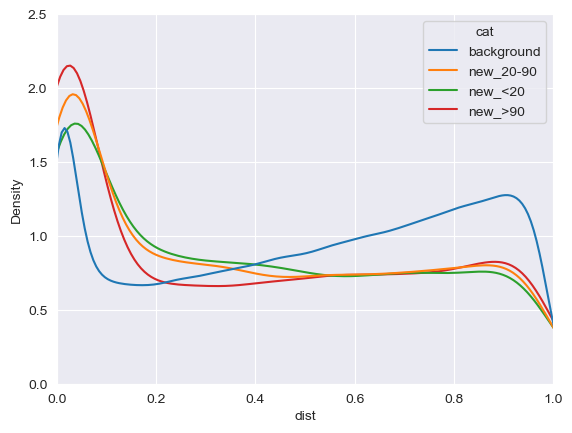

In [12]:
sns.kdeplot(frame5,  x='dist', hue='cat', common_norm=False)

_ = plt.xlim(0, 1)
_ = plt.ylim(0, 2.5)

plt.savefig("figs/main3a_5.pdf")

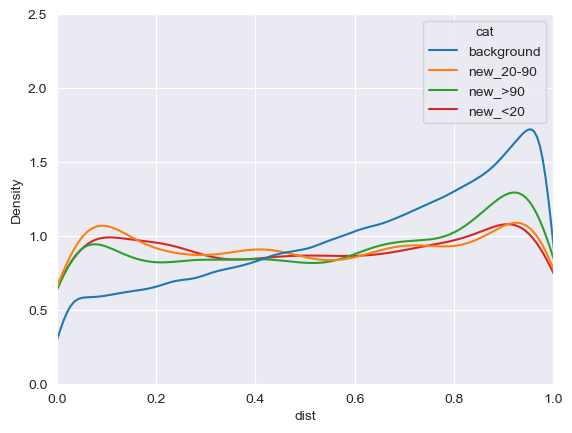

In [13]:
sns.kdeplot(frame3,  x='dist', hue='cat', common_norm=False)

_ = plt.xlim(0, 1)
_ = plt.ylim(0, 2.5)

plt.savefig("figs/main3a_3.pdf")

In [14]:
long_data = list()

In [15]:
for p in exon_type_repr:
    for cat in exon_type_repr[p]:
        tot = sum(exon_type_repr[p][cat].values())

        for exon_type in exon_type_repr[p][cat]:
            percent = exon_type_repr[p][cat][exon_type] / tot * 100

            long_data.append({
                'p': p,
                'cat': cat,
                'exon_type': exon_type,
                'percent': percent,
            })

In [16]:
frame = pd.DataFrame(long_data)

In [17]:
frame5 = frame[frame['p'] == '5']
frame3 = frame[frame['p'] == '3']

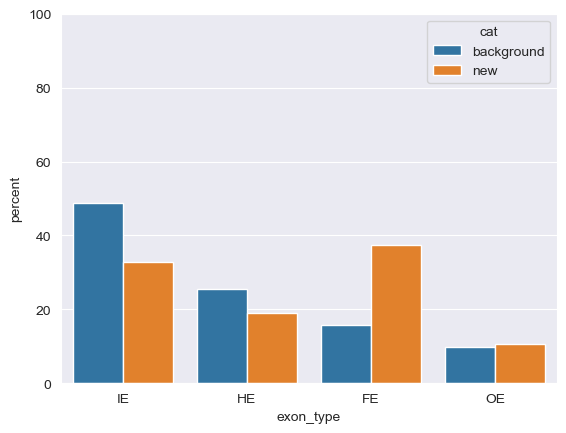

In [18]:
sns.barplot(frame5, x='exon_type', y='percent', hue='cat')

_ = plt.ylim(0, 100)
plt.savefig("figs/main3b_5.pdf")

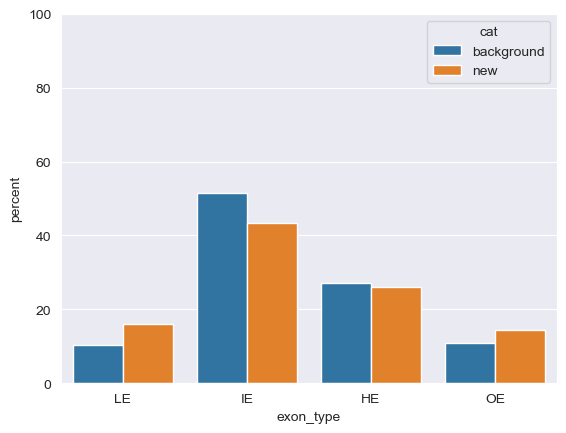

In [19]:
sns.barplot(frame3, x='exon_type', y='percent', hue='cat')

_ = plt.ylim(0, 100)
plt.savefig("figs/main3b_3.pdf")